In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

    


model = torch.load(
"./results/trained_pytorch_models/Masked_Phe/Model_GIN_classifier_to_explain_v2_27-10-2022_16h_31min_best_ValAcc_0.9147491512636741_epoch_91.pt")
#loader_path = "./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt"
loader_path = "./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt"
loader = torch.load(loader_path)
#loader_validation = loader.get_validation_loader()
loader_train = loader.get_train_loader()
############################
##############################
explainer  = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
model.to(device, non_blocking=True)
#a_batch = next(iter(loader_validation)).to(device, non_blocking=True)



/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


GIN_classifier_to_explain_v2(
  (GIN_layers): GIN(1, 8, num_layers=2)
  (FC1): Linear(in_features=8, out_features=1, bias=True)
  (FC2): Linear(in_features=11264, out_features=tensor([2]), bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)

In [2]:
model.eval()
gc.collect()
torch.cuda.empty_cache() 
edge_num           = loader_train.dataset[0].edge_index.shape[1]
all_graphs_weights = []#torch.empty(edge_num,1).to(device)

for graph in loader_train.dataset:
    _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
    
    #all_graphs_weights = torch.cat((all_graphs_weights, edge_weights.reshape(edge_num,1).to(device)), dim=1)
    all_graphs_weights.append(edge_weights.reshape(edge_num,1))
    

Explain graph: 100%|██████████| 1000/1000 [00:01<00:00, 666.68it/s]


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

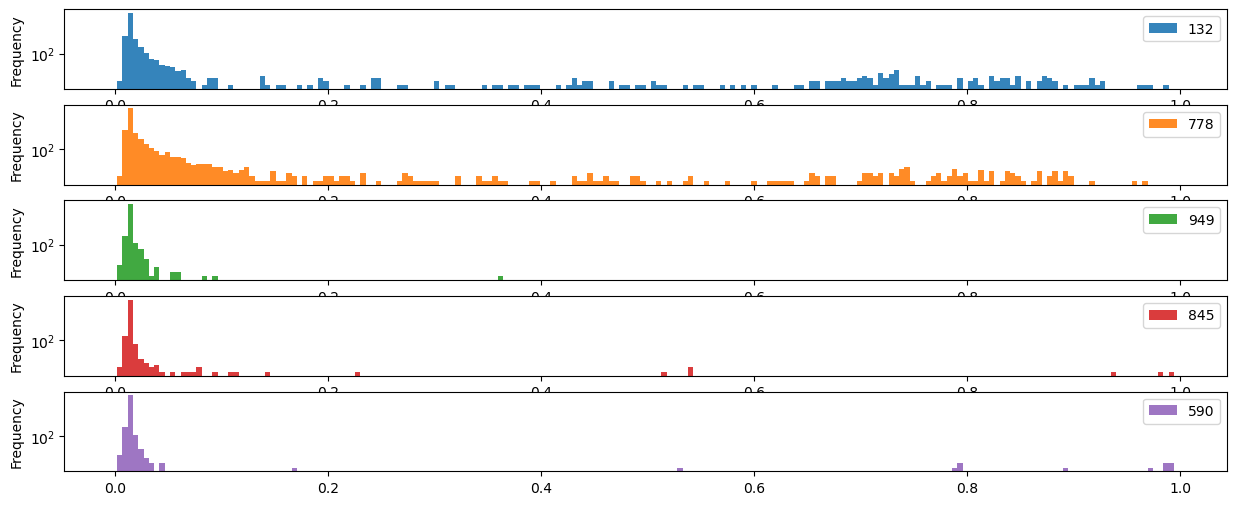

In [9]:
import numpy as np
all_graphs_weights_df = pd.DataFrame(
torch.stack(all_graphs_weights,1).squeeze().cpu().numpy())



all_graphs_weights_df.loc[:,np.random.randint(1, 1000, 5)].plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)


In [11]:
train_labels = []
for graph in tqdm.tqdm(loader_train.dataset):
    train_labels.append(graph.y.cpu().item())
assert train_labels.__len__() == all_graphs_weights_df.shape[1]
#all_graphs_weights.shape

labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
pd.Series(labels).to_csv("./results/data/data_for_R/Mask_train_labels.csv")

100%|██████████| 4921/4921 [00:00<00:00, 781351.07it/s]


In [8]:
all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]

all_graphs_weights_df.to_parquet('./results/data/data_for_R/Masked_graphs_weights_from_explainer.parquet.gzip', compression = 'gzip')
